In [22]:
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.operators import PolynomialTensor
from qiskit_nature.second_q.properties import ElectronicDipoleMoment
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit_nature.second_q.circuit.library import HartreeFock, UCC
import numpy as np 
from qiskit.primitives import Estimator
from qiskit_algorithms.optimizers import COBYLA , SLSQP, L_BFGS_B, SPSA, NELDER_MEAD
from qiskit_algorithms import VQE
from qiskit_algorithms.eigensolvers import NumPyEigensolver
from qiskit.quantum_info import SparsePauliOp
from qiskit.quantum_info import Statevector 


Gamma = 0.25
E0 = 0.01

driver = PySCFDriver(
    atom="H 0 0 0; H 0 0 0.735",
    basis="sto3g",
    charge=0,
    spin=0,
    unit=DistanceUnit.ANGSTROM,
)


problem = driver.run()
hamiltonian = problem.hamiltonian
dipole: ElectronicDipoleMoment  = problem.properties.electronic_dipole_moment

mapper = JordanWignerMapper()
dipole_ops = dipole.second_q_ops()

x_dipole_op = dipole_ops["XDipole"]
y_dipole_op = dipole_ops["YDipole"]
z_dipole_op = dipole_ops["ZDipole"]

qubit_dipole_ops = {
    "XDipole": mapper.map(x_dipole_op),
    "YDipole": mapper.map(y_dipole_op),
    "ZDipole": mapper.map(z_dipole_op),
}

qubit_dipole_ops_matrix = {
    "XDipole": qubit_dipole_ops["XDipole"].to_matrix(),
    "YDipole": qubit_dipole_ops["YDipole"].to_matrix(),
    "ZDipole": qubit_dipole_ops["ZDipole"].to_matrix(),
}

dipole_qubit = qubit_dipole_ops["XDipole"] + qubit_dipole_ops["YDipole"] + qubit_dipole_ops["ZDipole"]  
dipole_matrix = qubit_dipole_ops_matrix["XDipole"] + qubit_dipole_ops_matrix["YDipole"] + qubit_dipole_ops_matrix["ZDipole"] 


second_q_op = hamiltonian.second_q_op()
qubit_jw_op = mapper.map(second_q_op) 

H_0 = qubit_jw_op 
H_static = H_0.to_matrix() 

ansatz = UCC(
    num_spatial_orbitals = problem.num_spatial_orbitals, #2
    num_particles = problem.num_particles, # [1, 1]
    excitations='sd',
    qubit_mapper=mapper,
    initial_state=HartreeFock(
        num_spatial_orbitals = problem.num_spatial_orbitals,
        num_particles = problem.num_particles, 
        qubit_mapper=mapper,
    ),
    reps=1,

)

estimator = Estimator()
optimizer = SLSQP(maxiter=200)
vqe = VQE(estimator, ansatz, optimizer)
res = vqe.compute_minimum_eigenvalue(qubit_jw_op)

numpy_solver = NumPyEigensolver()
exact_result = numpy_solver.compute_eigenvalues(qubit_jw_op)
ref_value = exact_result.eigenvalues

circuit = ansatz.assign_parameters(res.optimal_parameters)
psi_0_vqe = np.array(Statevector(circuit).data)

def Hamilton_SP(t, H_0, z_dipole_qubit, E0, Gamma):
    t_float = float(t)  # Chuyển đổi t sang float 
    E_t = (E0 / np.pi) * Gamma / (Gamma**2 + t_float**2)
    V_t = E_t*z_dipole_qubit
    H_total_q = H_0 + V_t
    return H_total_q

def H_time(t):
    return Hamilton_SP(t, H_0, dipole_qubit, E0, Gamma)

In [3]:
static_pauli_op = H_0 
static_labels = static_pauli_op.paulis.to_labels()
dipole_pauli_op = dipole_qubit
dipole_interaction_labels = dipole_pauli_op.paulis.to_labels()
combined_unique_labels = list(dict.fromkeys(static_labels + dipole_interaction_labels))
num_qubits = H_0.num_qubits

In [4]:
from qiskit.quantum_info import random_unitary
from qiskit.circuit.library import UnitaryGate
from sync import cost as cost_func
from sync import circuit, constant
import pennylane.numpy as np
import pennylane as qml
%load_ext autoreload
%autoreload 2

In [5]:
def pennylane_ansatz_from_qiskit_pauli_evo(thetas, num_qubits, pauli_labels, num_layers):
    
    if not pauli_labels:
        raise ValueError("pauli_labels must not be empty.")


    num_params_per_layer = len(pauli_labels)
    num_params_expected = num_params_per_layer * num_layers

    if len(thetas) != num_params_expected:
         raise ValueError(f"Expected {num_params_expected} parameters, got {len(thetas)}.")

    
    param_idx = 0
    for _ in range(num_layers):
        for pauli_qiskit_str in pauli_labels:
            if len(pauli_qiskit_str) != num_qubits:
                raise ValueError(f"Pauli string '{pauli_qiskit_str}' does not match num_qubits={num_qubits}.")
            
            pennylane_observable = None
            if all(c == 'I' for c in pauli_qiskit_str):
                if num_qubits > 0:
                    pennylane_observable = qml.Identity(0)
                    for i_w in range(1, num_qubits): pennylane_observable @= qml.Identity(i_w)
                elif num_qubits == 0: pennylane_observable = qml.Identity(0)
                else: raise ValueError("Số qubit phải không âm.")
            else:
                try: pennylane_observable = qml.pauli.string_to_pauli_word(pauli_qiskit_str)
                except AttributeError:

                    ops_list = []
                    for i_wire in range(num_qubits):
                        char = pauli_qiskit_str[i_wire]
                        if char == 'X': ops_list.append(qml.PauliX(i_wire))
                        elif char == 'Y': ops_list.append(qml.PauliY(i_wire))
                        elif char == 'Z': ops_list.append(qml.PauliZ(i_wire))
                        elif char == 'I': pass
                        else: raise ValueError(f"Ký tự Pauli không hợp lệ '{char}'")

                    if not ops_list and num_qubits > 0:
                         pennylane_observable = qml.Identity(0)
                         for i_w in range(1, num_qubits): pennylane_observable @= qml.Identity(i_w)
                    elif ops_list: pennylane_observable = qml.prod(*ops_list)
                    else: raise ValueError(f"Không tạo được observable từ '{pauli_qiskit_str}'")
            if pennylane_observable is not None: qml.exp(pennylane_observable, -1j * thetas[param_idx])
            param_idx += 1
# --- Kết thúc hàm ansatz ---

In [23]:

import numpy as np
from scipy.integrate import solve_ivp
import time

H0_matrix = H_static
Dz_matrix = dipole_matrix

dim = H0_matrix.shape[0]
U0_flat = np.eye(dim, dtype=complex).flatten() 


E0 = 0.01
Gamma = 0.25

def E_field(t):
    if t < -200 or t > 200: return 0.0
    return (E0 / np.pi) * Gamma / (Gamma**2 + t**2)

# Hàm H(t)
def H_t_matrix(t):
    return H0_matrix + E_field(t) * Dz_matrix


def unitary_rhs(t, U_flat):
    U = U_flat.reshape(dim, dim) 
    H = H_t_matrix(t)
    dU_dt = -1j * (H @ U)
    return dU_dt.flatten()

times_for_training = np.linspace(0, 100,20) 
t_span = [times_for_training[0], times_for_training[-1]]

print("Bắt đầu tính toán Target Unitaries bằng ODE Solver...")
start_time = time.time()
sol_U = solve_ivp(
    unitary_rhs,
    t_span,
    U0_flat,
    t_eval=times_for_training,
    method='RK45', 
    rtol=1e-8,
    atol=1e-8
)
end_time = time.time()
print(f"Hoàn thành trong {end_time - start_time:.2f} giây.")

target_unitaries_list = []
if sol_U.success:
    unitaries_flat = sol_U.y.T 
    for u_flat in unitaries_flat:
        target_unitaries_list.append(u_flat.reshape(dim, dim))
    print(f"Đã tạo thành công {len(target_unitaries_list)} target unitaries.")
else:
    print("Lỗi: Bộ giải ODE không hội tụ khi tính toán Unitary.")


Bắt đầu tính toán Target Unitaries bằng ODE Solver...
Hoàn thành trong 0.07 giây.
Đã tạo thành công 20 target unitaries.


In [16]:
import math
import numpy as np
import pennylane as qml
import pennylane.numpy as pnp
from numpy.random import Generator, PCG64

num_layers = 6
times = np.linspace(0, 100,20)
steps = 300
learning_rate = 0.01
error_threshold = constant.error

num_qubits = H_0.num_qubits
pauli_labels = combined_unique_labels
num_thetas = len(pauli_labels) * num_layers
rng = Generator(PCG64())
init_thetas = pnp.array(2 * math.pi * rng.random(size=num_thetas), requires_grad=True)

def vqa_cost(thetas, num_qubits, pauli_labels, num_layers, target_unitary):
    ansatz_matrix = qml.matrix(pennylane_ansatz_from_qiskit_pauli_evo, wire_order=list(range(num_qubits)))(
        thetas, num_qubits, pauli_labels, num_layers
    )
    return cost_func.c_hst(ansatz_matrix, target_unitary)

def train_vqa_for_time(target_unitary, num_qubits, pauli_labels, num_layers, init_thetas, steps, learning_rate, error_threshold):
    opt = qml.AdamOptimizer(stepsize=learning_rate)
    thetas = init_thetas.copy()
    cost_history = []
    for n in range(steps):
        cost_fn = lambda th: vqa_cost(th, num_qubits, pauli_labels, num_layers, target_unitary)
        thetas, prev_cost = opt.step_and_cost(cost_fn, thetas)
        if (n + 1) % (steps // 2 if steps >= 2 else 1) == 0:
            print(f"    Opt. step {n+1}/{steps}, Cost: {prev_cost:.6f}")
        if prev_cost < error_threshold:
            print(f"    Reached error threshold at step {n+1}")
            # break
        cost_history.append(prev_cost)
    return thetas, cost_history

optimized_unitaries = {}
evolved_states = {}

print("Starting VQA time evolution simulation with Pennylane")
for i, t in enumerate(times):
    print(f"\n--- Time t = {t:.4f} ---")
    target = target_unitaries_list[i]
    thetas, cost_history = train_vqa_for_time(
        target, num_qubits, pauli_labels, num_layers, init_thetas,
        steps=steps, learning_rate=learning_rate, error_threshold=error_threshold
    )
    U_theta_t = qml.matrix(
        pennylane_ansatz_from_qiskit_pauli_evo, wire_order=range(num_qubits)
    )(thetas, num_qubits, pauli_labels, num_layers)
    optimized_unitaries[t] = U_theta_t.numpy() if hasattr(U_theta_t, 'numpy') else np.asarray(U_theta_t)
    psi_0_col = psi_0_vqe.reshape(-1, 1)
    psi_t_col_approx = optimized_unitaries[t] @ psi_0_col
    psi_t_approx = psi_t_col_approx.flatten()
    evolved_states[t] = psi_t_approx

Starting VQA time evolution simulation with Pennylane

--- Time t = 0.0000 ---
    Opt. step 150/300, Cost: 0.146447
    Opt. step 300/300, Cost: 0.146447

--- Time t = 5.2632 ---
    Reached error threshold at step 102
    Reached error threshold at step 103
    Reached error threshold at step 104
    Reached error threshold at step 105
    Reached error threshold at step 106
    Reached error threshold at step 107
    Reached error threshold at step 108
    Reached error threshold at step 109
    Reached error threshold at step 110
    Reached error threshold at step 111
    Reached error threshold at step 112
    Reached error threshold at step 113
    Reached error threshold at step 114
    Reached error threshold at step 115
    Reached error threshold at step 116
    Reached error threshold at step 117
    Reached error threshold at step 118
    Reached error threshold at step 119
    Reached error threshold at step 120
    Reached error threshold at step 121
    Reached error th

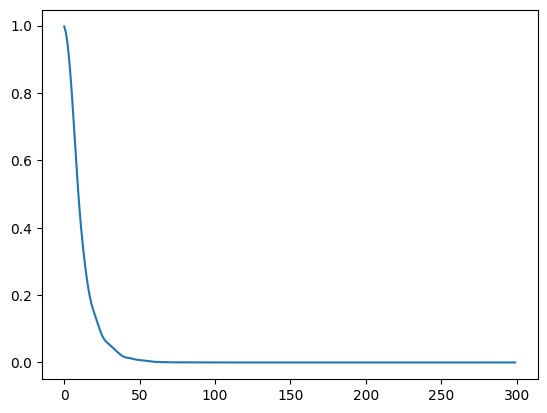

In [17]:
import matplotlib.pyplot as plt
plt.plot(cost_history)

In [8]:


import numpy as np

output_filename = "cost_thesis_perfect.txt"

try:
    if 'costs' not in locals():
        raise NameError("Không tìm thấy biến 'costs'. Vui lòng chạy lại một ô code có quá trình tối ưu hóa để tạo ra biến này.")

    numeric_costs = [float(c) for c in cost_history]
    
    print(f"Đã trích xuất thành công {len(numeric_costs)} giá trị cost từ lần chạy cuối.")

    print(f"Đang ghi kết quả ra file '{output_filename}'...")
    
    with open(output_filename, "w") as f:
        f.write("# Optimization_Step   Cost_Value\n")
        
        for step, cost_value in enumerate(numeric_costs):
            f.write(f"{step + 1:<20} {cost_value:<.12f}\n")
            
    print(f"\nHoàn tất! Đã lưu thành công lịch sử cost vào file '{output_filename}'.")

except Exception as e:
    print(f"Đã xảy ra lỗi không mong muốn: {e}")

Đã xảy ra lỗi không mong muốn: Không tìm thấy biến 'costs'. Vui lòng chạy lại một ô code có quá trình tối ưu hóa để tạo ra biến này.


In [41]:
# --- Hàm giải phương trình Schrödinger chính xác bằng ODE Solver ---
from scipy.integrate import solve_ivp
from qiskit.quantum_info import Statevector, Operator
import numpy as np
import time

def calculate_expectation_value(state_vector_flat, pauli_op_sparse):
    if pauli_op_sparse is None or state_vector_flat is None:
        return np.nan
    try:
        sv = Statevector(np.ascontiguousarray(state_vector_flat))
        exp_val = sv.expectation_value(pauli_op_sparse)
        return exp_val.real
    except Exception as e_exp:
        print(f"    Lỗi khi tính giá trị kỳ vọng: {e_exp}")
        return np.nan

print("Bắt đầu chạy mô phỏng chính xác (ODE)...")
start_run_time = time.time()

H_static_mat_for_ode = H_0.to_matrix(sparse=False)
z_dipole_mat_for_ode = dipole_matrix

E0 = 0.01
Gamma = 0.25
def E_field_for_ode(t):
    return (E0 / np.pi) * Gamma / (Gamma**2 + t**2)


def schrodinger_rhs(t, psi_flat):
    H_t_mat = H_static_mat_for_ode + E_field_for_ode(t) * z_dipole_mat_for_ode
    return -1j * H_t_mat @ psi_flat


times_for_ode_plot =  np.linspace(0, 300,50) 
initial_state_vec_for_ode = psi_0_vqe


ode_solution = solve_ivp(
    schrodinger_rhs,
    t_span=[times_for_ode_plot[0], times_for_ode_plot[-1]],
    y0=initial_state_vec_for_ode,
    t_eval=times_for_ode_plot,
    rtol=1e-8,
    atol=1e-8
)

if ode_solution.success:
    print("Giải ODE thành công.")
    all_psi_t_exact_ode = ode_solution.y.T
else:
    print("Giải ODE thất bại:", ode_solution.message)
    all_psi_t_exact_ode = np.array([initial_state_vec_for_ode] * len(times_for_ode_plot))


muz_plot_exact_ode = []
for psi_t in all_psi_t_exact_ode:
    exp_val = calculate_expectation_value(psi_t, dipole_qubit)
    muz_plot_exact_ode.append(exp_val)

end_run_time = time.time()
print(f"Đã tính xong dipole moment từ kết quả ODE. Thời gian: {end_run_time - start_run_time:.2f} giây")
# if len(muz_plot_exact_ode) > 0 and np.any(~np.isnan(muz_plot_exact_ode)):
#     plt.plot(times_for_ode_plot, muz_plot_exact_ode, label="$\mu_z(t)$ - ODE", marker='', linestyle='-')

Bắt đầu chạy mô phỏng chính xác (ODE)...
Giải ODE thành công.
Đã tính xong dipole moment từ kết quả ODE. Thời gian: 0.22 giây
Giải ODE thành công.
Đã tính xong dipole moment từ kết quả ODE. Thời gian: 0.22 giây


In [40]:
import numpy as np
from scipy.linalg import expm 
from qiskit.quantum_info import Operator, Statevector 
import time

# --- Cấu hình và các hàm pomocniczy (giữ nguyên từ trước) ---

D_mat = dipole_matrix     
DIM = 2**num_qubits
Gamma = 0.25
E0 = 0.01

def f_lorentzian(t, E0, Gamma): 
    return (E0 / np.pi) * Gamma / (Gamma**2 + t**2)

def f_integral(t_start, t_end, E0, Gamma):
    return (E0/ np.pi) * (np.arctan(t_end / Gamma) - np.arctan(t_start / Gamma))

def trapezoidal_weights(n_points):
    if n_points <= 1: return np.array([1.0]) if n_points == 1 else np.array([])
    weights_val = np.ones(n_points)
    weights_val[0] = weights_val[-1] = 0.5
    return weights_val * (1.0 / (n_points - 1))

print("Tính toán trước [H0, D]...")
Comm_H0_D = H_static @ D_mat -  D_mat @ H_static

M_inner_integral = 50 # Số điểm tích phân cho mỗi bước Magnus

def compute_U_step_magnus2(t_j_start, h_step): 
    if h_step == 0:
        return np.eye(DIM, dtype=complex)
    
    Omega1 = -1j * (H_static * h_step + D_mat * f_integral(t_j_start, t_j_start + h_step, E0, Gamma))
    
    Omega2 = np.zeros((DIM, DIM), dtype=complex)
    if M_inner_integral > 1:
        t_points_inner = np.linspace(t_j_start, t_j_start + h_step, M_inner_integral)
        delta_t_inner = h_step / (M_inner_integral - 1)
        weights_inner = trapezoidal_weights(M_inner_integral) * delta_t_inner
        f_values_inner = f_lorentzian(t_points_inner, E0, Gamma)

        for p in range(M_inner_integral):
            t1 = t_points_inner[p]
            f_t1 = f_values_inner[p]
            integral_f_t2_up_to_t1 = f_integral(t_j_start, t1, E0, Gamma)
            term_for_outer_integral = integral_f_t2_up_to_t1 - (f_t1 * (t1 - t_j_start))
            Omega2 += term_for_outer_integral * Comm_H0_D * weights_inner[p]
            
    Omega2 *= -0.5
    
    Omega = Omega1 + Omega2
    U_step = expm(Omega)
    return U_step

print("\\nBắt đầu mô phỏng Magnus bậc 2 với bước thời gian nhỏ...")
start_run_time = time.time()


times = np.linspace(0,300,50)
times_plot = times 
dt_magnus = 0.1 


T_final = times_plot[-1]

current_t = 0.0

all_psi_t_magnus_map = {0.0: Statevector(psi_0_vqe)}

psi_current_iter = Statevector(psi_0_vqe)

plot_idx = 1 

while current_t < T_final and plot_idx < len(times_plot):

    h = times_plot[plot_idx] - current_t

    num_sub_steps = max(1, int(np.ceil(h / dt_magnus)))
    dt_sub_step = h / num_sub_steps

    psi_at_h = psi_current_iter
    
    for i in range(num_sub_steps):
        t_sub_step_start = current_t + i * dt_sub_step
        U_sub_step = compute_U_step_magnus2(t_sub_step_start, dt_sub_step)
        psi_at_h = psi_at_h.evolve(Operator(U_sub_step))


    all_psi_t_magnus_map[times_plot[plot_idx]] = psi_at_h
    

    current_t = times_plot[plot_idx]
    psi_current_iter = psi_at_h
    plot_idx += 1
    
end_run_time = time.time()
print(f"Hoàn thành mô phỏng. Thời gian: {end_run_time - start_run_time:.2f} giây")


Tính toán trước [H0, D]...
\nBắt đầu mô phỏng Magnus bậc 2 với bước thời gian nhỏ...
Hoàn thành mô phỏng. Thời gian: 0.99 giây
Hoàn thành mô phỏng. Thời gian: 0.99 giây


In [32]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit.quantum_info import Statevector, Operator, SparsePauliOp 
import qiskit 

def calculate_expectation_value(state_vector_flat, pauli_op_sparse):
    if pauli_op_sparse is None or state_vector_flat is None:
        return np.nan
    sv = Statevector(state_vector_flat)
    try:
        exp_val = sv.expectation_value(pauli_op_sparse)
        return exp_val.real 
    except Exception as e_exp:
        print(f"    Lỗi khi tính giá trị kỳ vọng: {e_exp}")
        return np.nan
    
times_plot_magnus2 = []
muz_plot_magnus2 = []


# Magnus2 

sorted_times_magnus = sorted(all_psi_t_magnus_map.keys())
for t_current in sorted_times_magnus:       
    psi_t_magnus_current = all_psi_t_magnus_map[t_current]
    
    if psi_t_magnus_current is not None:
        # print(f"  Tính toán cho t = {t_current:.4f} (Magnus2)") # Bỏ comment nếu cần debug
        times_plot_magnus2.append(t_current)
        muz_plot_magnus2.append(calculate_expectation_value(psi_t_magnus_current, dipole_qubit))
    else:
        times_plot_magnus2.append(t_current)
        muz_plot_magnus2.append(np.nan)

times_plot_np_magnus2 = np.array(times_plot_magnus2)
muz_plot_np_magnus2 = np.array(muz_plot_magnus2)

#Vẽ đường từ kết quả Magnus2
# if muz_plot_np_magnus2.size > 0 and np.any(~np.isnan(muz_plot_np_magnus2)):
#     plt.plot(times_plot_np_magnus2, muz_plot_np_magnus2, label="$\mu_z(t)$ - Magnus2", marker='', linestyle='-')

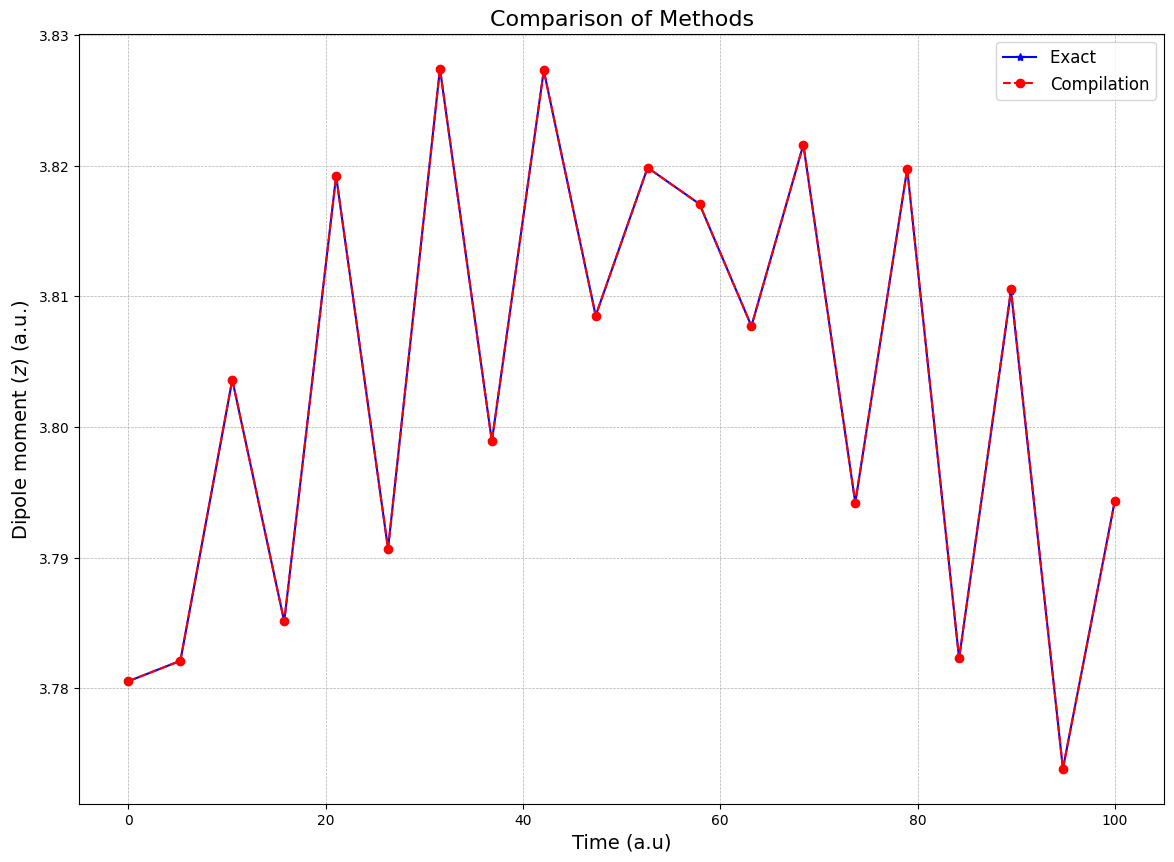

In [21]:
import matplotlib.pyplot as plt
import numpy as np

times_plot_pennylane_new = sorted(evolved_states.keys())
muz_plot_pennylane_new = []

for t in times_plot_pennylane_new:
    psi_t_current = evolved_states.get(t)
    if psi_t_current is not None:

        exp_val = np.real(psi_t_current.conj().T @ dipole_matrix @ psi_t_current)
        muz_plot_pennylane_new.append(exp_val)


plt.figure(figsize=(14, 10))

if 'muz_plot_exact_ode' in locals() or 'muz_plot_exact_ode' in globals():
    plt.plot(times, muz_plot_exact_ode, label="Exact ", color='blue',marker='*', linestyle='-')

# Kết quả VQA mới (huấn luyện trên target chuẩn)
if muz_plot_pennylane_new:
    plt.plot(times_plot_pennylane_new, muz_plot_pennylane_new, label="Compilation", linestyle='--', marker='o', color='red', markersize=6)
    
# Kết quả VQA cũ (huấn luyện trên target xấp xỉ)
# if 'muz_plot_pennylane' in locals() or 'muz_plot_pennylane' in globals():
#     plt.plot(times_pennylane, muz_plot_pennylane, label="VQA (Trained on Integral Approx.)", marker='^', linestyle=':', color='orange', alpha=0.8)

# Các phương pháp xấp xỉ khác
# if 'muz_plot_trotter_t2' in locals() or 'muz_plot_trotter_t2' in globals():
#     plt.plot(times_for_trotter_plot, muz_plot_trotter_t2, label="Trotter 2nd", linestyle='-.',marker ='x', color='green', alpha=1)
# if 'muz_plot_magnus2' in locals() or 'muz_plot_magnus2' in globals():
#     plt.plot(times_plot_magnus2, muz_plot_np_magnus2, label="Magnus 2nd", linestyle='--',marker ='^', color='purple', alpha=1)
# if 'muz_plot_trotter_t1' in locals() or 'muz_plot_trotter_t1' in globals():
#     plt.plot(times_for_trotter_plot, muz_plot_trotter_t1, label="Trotter 1st", linestyle=':', marker='*', color='yellow', alpha=1)


# --- Định dạng đồ thị ---
plt.xlabel("Time (a.u)", fontsize=14)
plt.ylabel("Dipole moment ($z$) (a.u.)", fontsize=14)
plt.title("Comparison of Methods", fontsize=16)
plt.legend(fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()


In [29]:
from qiskit.circuit.library import PauliEvolutionGate
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector
import numpy as np
from qiskit.quantum_info import Operator
import matplotlib.pyplot as plt

E0 = 0.01
Gamma = 0.25
def E_field(t):
    return (E0 / np.pi) * Gamma / (Gamma**2 + t**2)

def run_trotter_simulation(total_time, num_steps, H_static, H_dynamic_op, E_func, initial_state, order=1):
    num_qubits = H_static.num_qubits
    dt = total_time / num_steps

    circuit = QuantumCircuit(num_qubits)
    circuit.initialize(initial_state, range(num_qubits))
    
    for i in range(num_steps):
        t = (i + 0.5) * dt 
        E_t = E_func(t)
        
        if order == 1:
            # Trotter bậc 1: U(dt) ≈ exp(-i*H0*dt) * exp(-i*V(t)*dt)
            circuit.append(PauliEvolutionGate(H_static, time=dt), range(num_qubits))
            circuit.append(PauliEvolutionGate(H_dynamic_op, time=E_t * dt), range(num_qubits))
        elif order == 2:
            # Trotter bậc 2: U(dt) ≈ exp(-i*H0*dt/2) * exp(-i*V(t)*dt) * exp(-i*H0*dt/2)
            circuit.append(PauliEvolutionGate(H_static, time=dt/2), range(num_qubits))
            circuit.append(PauliEvolutionGate(H_dynamic_op, time=E_t * dt), range(num_qubits))
            circuit.append(PauliEvolutionGate(H_static, time=dt/2), range(num_qubits))
        else:
            raise ValueError("Bậc Trotter phải là 1 hoặc 2.")
            
    final_state = Statevector(circuit)
    return final_state.data

In [28]:
H0_op = H_0 
z_dipole_op = dipole_qubit
psi0_vec = psi_0_vqe
num_qubits = H0_op.num_qubits

Bắt đầu mô phỏng Trotter để tính dipole moment...
Hoàn thành mô phỏng Trotter.


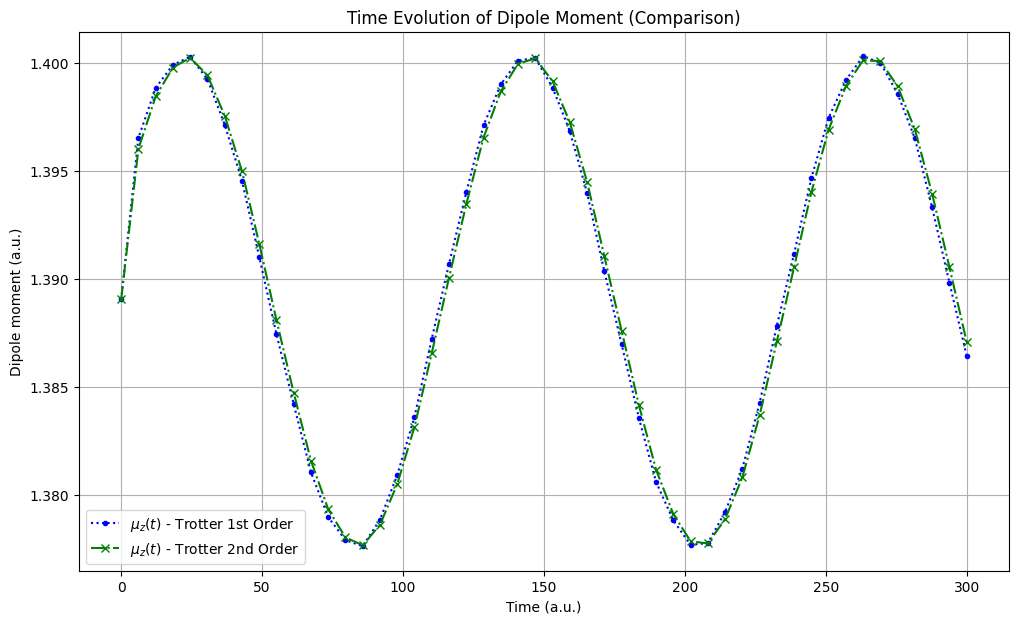

In [ ]:

times_for_trotter_plot = times
initial_state_vec = psi_0_vqe

muz_plot_trotter_t1 = []
muz_plot_trotter_t2 = []

steps_per_au = 10 

print("Bắt đầu mô phỏng Trotter để tính dipole moment...")

def calculate_expectation_value(state_vector_flat, pauli_op_sparse):
    if pauli_op_sparse is None or state_vector_flat is None:
        return np.nan
    sv = Statevector(state_vector_flat)
    try:
        exp_val = sv.expectation_value(pauli_op_sparse)
        return exp_val.real 
    except Exception as e_exp:
        print(f"    Lỗi khi tính giá trị kỳ vọng: {e_exp}")
        return np.nan

for t in times_for_trotter_plot:

    if t == 0:
        psi_t_t1 = initial_state_vec
        psi_t_t2 = initial_state_vec
    else:

        num_steps = max(1, int(t * steps_per_au))
        psi_t_t1 = run_trotter_simulation(t, num_steps, H_0, dipole_qubit, E_field, initial_state_vec, order=1)
        psi_t_t2 = run_trotter_simulation(t, num_steps, H_0, dipole_qubit, E_field, initial_state_vec, order=2)


    muz_t1 = calculate_expectation_value(psi_t_t1, dipole_qubit)
    muz_t2 = calculate_expectation_value(psi_t_t2, dipole_qubit)
    
    muz_plot_trotter_t1.append(muz_t1)
    muz_plot_trotter_t2.append(muz_t2)

print("Hoàn thành mô phỏng Trotter.")



plt.figure(figsize=(12, 7))

# Dữ liệu từ các ô trước: Exact và VQA
#plt.plot(times_exact, muz_plot_exact, label="$\\mu_z(t)$ - Exact", marker='*', linestyle='--', color='black', zorder=5)
#plt.plot(times_pennylane, muz_plot_pennylane, label="$\\mu_z(t)$ - VQA", marker='^', linestyle='-', color='red')

# Dữ liệu Trotter vừa tính
plt.plot(times_for_trotter_plot, muz_plot_trotter_t1, label="$\\mu_z(t)$ - Trotter 1st Order", linestyle=':', marker='.', color='blue')
plt.plot(times_for_trotter_plot, muz_plot_trotter_t2, label="$\\mu_z(t)$ - Trotter 2nd Order", linestyle='-.', marker='x', color='green')

plt.xlabel("Time (a.u.)")
plt.ylabel("Dipole moment (a.u.)")
plt.title("Time Evolution of Dipole Moment (Comparison)")
plt.legend()
plt.grid(True)
plt.show()


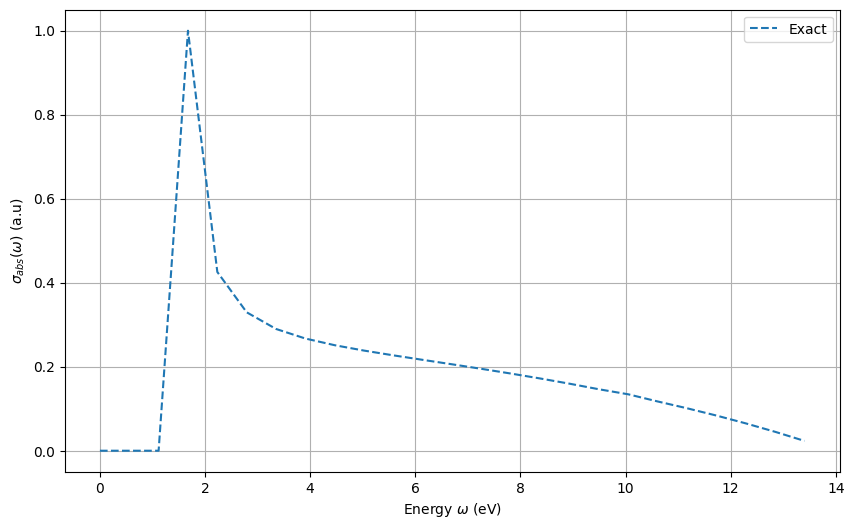

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fftfreq, fftshift
from scipy import fftpack
from scipy.signal import windows
from scipy.constants import speed_of_light, physical_constants

# ================== KIỂM TRA INPUT ===================
if len(times_for_ode_plot) < 2:
    raise ValueError("Cần ít nhất 2 điểm thời gian để thực hiện FFT.")

# ================== THAM SỐ ===================
dt = times_for_ode_plot[1] - times_for_ode_plot[0]
N_points = len(times_for_ode_plot)
times = np.array(times_for_ode_plot)

gamma = 0.001
E0 = 0.01
Gamma = 0.25

Speed_of_light_au = speed_of_light / physical_constants["atomic unit of velocity"][0]
T = 300 
# damping = np.pi/T
# gamma = np.pi/T

# ================== HÀM HỖ TRỢ ===================

def damping(signal, dt, gamma):
    """Áp dụng hệ số tắt dần lên tín hiệu."""
    t = np.arange(len(signal)) * dt
    return signal * np.exp(-gamma * t)

# def windowed(signal):
#     """Áp dụng cửa sổ Blackman để giảm ringing."""
#     return signal * windows.blackman(len(signal))

def f_t_lorentz(t, E0, Gamma):
    """Trường điện từ Lorentz."""
    return (E0 / np.pi) * Gamma / (Gamma**2 + t**2)

def fourier_transform(signal, dt):
    """Fourier transform với chuẩn hóa chuẩn vật lý."""
    c = dt / (2 * np.pi)
    N = len(signal) - (len(signal) % 2)  # làm chẵn nếu cần
    omega = fftpack.fftfreq(N, c)[:N // 2]
    F = N * c * fftpack.ifft(signal[:N], overwrite_x=True)[:N // 2]
    return omega, F

def absorption_spectrum(mu_omega, omega, E_omega, normalize=True):
    """Tính phổ hấp thụ từ mô men lưỡng cực và trường điện."""
    with np.errstate(divide='ignore', invalid='ignore'):
        alpha = np.zeros_like(mu_omega, dtype=complex)
        valid = np.abs(E_omega) > 1e-9
        alpha[valid] = mu_omega[valid] / E_omega[valid]
        sigma = (4 * np.pi * omega / Speed_of_light_au) * np.imag(alpha)
        sigma[sigma < 0] = 0
    return sigma / sigma.max() if normalize else sigma

def compute_discrete_spectrum(dipole_t, dt, E_t, gamma, normalize=True):
    """Tính phổ hấp thụ từ mô phỏng thời gian."""
    dipole_t = dipole_t - np.mean(dipole_t)
    dipole_damped = damping(dipole_t, dt, gamma)
    dipole_win = dipole_damped
    E_win = E_t

    omega, mu_omega = fourier_transform(dipole_win, dt)
    _, E_omega = fourier_transform(E_win, dt)

    sigma = absorption_spectrum(mu_omega, omega, E_omega, normalize)
    return omega, sigma

# ================== DỮ LIỆU TRƯỜNG VÀ DIPOLE ===================
E_t = f_t_lorentz(times, E0, Gamma)


# ================== TÍNH PHỔ ===================
# omega1, sigma1 = compute_discrete_spectrum(muz_plot_pennylane_new, dt, E_t, gamma)
# omega2, sigma2 = compute_discrete_spectrum(muz_plot_trotter_t1, dt, E_t, gamma)
omega3, sigma3 = compute_discrete_spectrum(muz_plot_exact_ode, dt, E_t, gamma)
# omega4, sigma4 = compute_discrete_spectrum(muz_plot_trotter_t2, dt, E_t, gamma)
# omega5, sigma5 = compute_discrete_spectrum(muz_plot_magnus2, dt, E_t, gamma)
hartree_to_ev = 27.211386245988
#omega_ev = omega_positive * hartree_to_ev

# ================== VẼ ĐỒ THỊ ===================
plt.figure(figsize=(10, 6))
# plt.plot(omega1*hartree_to_ev, sigma1, label='Compilation')
# plt.plot(omega2*hartree_to_ev, sigma2, label='Trotter 1st')
plt.plot(omega3*hartree_to_ev, sigma3, label='Exact', linestyle='--')
# plt.plot(omega4*hartree_to_ev, sigma4, label='Trotter 2nd')
# plt.plot(omega5*hartree_to_ev, sigma5, label='Magnus 2nd')
plt.xlabel("Energy $\\omega$ (eV)")
plt.ylabel("$\\sigma_{abs}(\\omega)$ (a.u)")
# plt.title("So sánh Phổ hấp thụ H2")
plt.grid(True)
plt.legend()
# plt.xlim(0, 1)  # Giới hạn để tập trung vào vùng quan tâm
# plt.ylim(bottom=0)
plt.show()

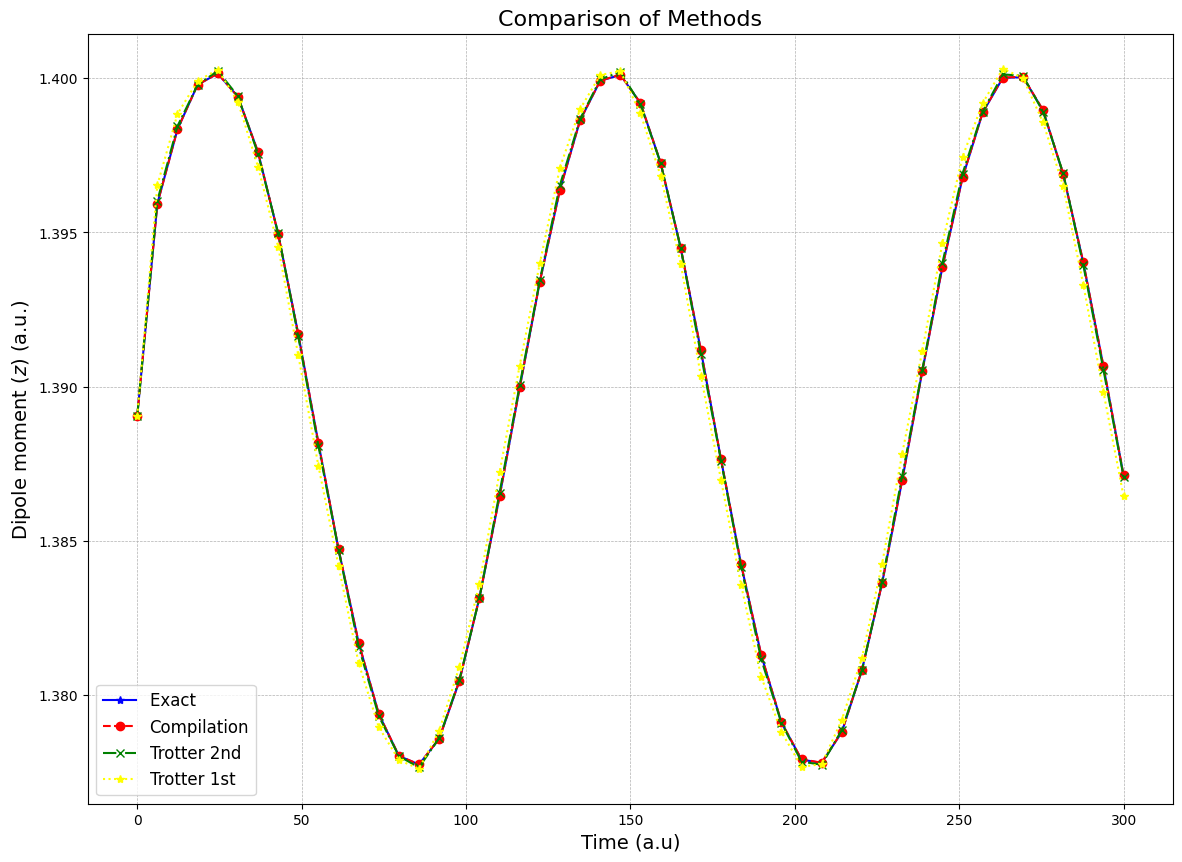

In [102]:
import matplotlib.pyplot as plt
import numpy as np

# --- Bước 1: Tính toán giá trị kỳ vọng từ kết quả VQA mới ---

# Lấy các biến từ ô huấn luyện VQA mới (id: ee90b4ad)
# Đảm bảo ô đó đã được chạy
times_plot_pennylane_new = sorted(evolved_states.keys())
muz_plot_pennylane_new = []

for t in times_plot_pennylane_new:
    psi_t_current = evolved_states.get(t)
    if psi_t_current is not None:
        # Sử dụng lại ma trận Dz_matrix đã định nghĩa ở các ô trước
        exp_val = np.real(psi_t_current.conj().T @ dipole_matrix @ psi_t_current)
        muz_plot_pennylane_new.append(exp_val)

# --- Bước 2: Vẽ đồ thị so sánh TẤT CẢ các phương pháp ---
plt.figure(figsize=(14, 10))

# Dữ liệu "Ground Truth" mới tính từ ODE
if 'muz_plot_exact_ode' in locals() or 'muz_plot_exact_ode' in globals():
    plt.plot(times, muz_plot_exact_ode, label="Exact ", color='blue',marker='*', linestyle='-')

# Kết quả VQA mới (huấn luyện trên target chuẩn)
if muz_plot_pennylane_new:
    plt.plot(times_plot_pennylane_new, muz_plot_pennylane_new, label="Compilation", linestyle='--', marker='o', color='red', markersize=6)
    
# Kết quả VQA cũ (huấn luyện trên target xấp xỉ)
# if 'muz_plot_pennylane' in locals() or 'muz_plot_pennylane' in globals():
#     plt.plot(times_pennylane, muz_plot_pennylane, label="VQA (Trained on Integral Approx.)", marker='^', linestyle=':', color='orange', alpha=0.8)

# Các phương pháp xấp xỉ khác
if 'muz_plot_trotter_t2' in locals() or 'muz_plot_trotter_t2' in globals():
    plt.plot(times_for_trotter_plot, muz_plot_trotter_t2, label="Trotter 2nd", linestyle='-.',marker ='x', color='green', alpha=1)
# if 'muz_plot_magnus2' in locals() or 'muz_plot_magnus2' in globals():
#     plt.plot(times_plot_magnus2, muz_plot_np_magnus2, label="Magnus 2nd", linestyle='--',marker ='^', color='purple', alpha=1)
if 'muz_plot_trotter_t1' in locals() or 'muz_plot_trotter_t1' in globals():
    plt.plot(times_for_trotter_plot, muz_plot_trotter_t1, label="Trotter 1st", linestyle=':', marker='*', color='yellow', alpha=1)


# --- Định dạng đồ thị ---
plt.xlabel("Time (a.u)", fontsize=14)
plt.ylabel("Dipole moment ($z$) (a.u.)", fontsize=14)
plt.title("Comparison of Methods", fontsize=16)
plt.legend(fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()


In [104]:
# CELL MỚI: LƯU KẾT QUẢ DIPOLE RA FILE TXT

import numpy as np

# Giả định rằng các biến này đã được tính toán ở các ô trước:
# - times_for_training: Mảng thời gian
# - muz_plot_exact_ode: Dữ liệu dipole từ ODE Solver (Exact)
# - muz_plot_pennylane_new: Dữ liệu dipole từ VQA đã được huấn luyện (Train)

output_filename = "dipole_thesis_perfect.txt"

try:
    with open(output_filename, "w") as f:
        # Ghi dòng tiêu đề cho các cột
        f.write("# Time (fs)   Dipole_Exact (a.u.)   Dipole_Train (a.u.)  Dipole_Trotter1 (a.u.)   Dipole_Trotter2 (a.u.)   Dipole_Magnus2 (a.u.)   \n")
        
        # Lặp qua từng điểm thời gian và ghi dữ liệu
        for i in range(len(times_for_training)):
            time_val = times_for_training[i]
            dipole_exact = muz_plot_exact_ode[i]
            dipole_magnus2 = muz_plot_magnus2[i]
            dipole_trotter1 = muz_plot_trotter_t1[i]
            dipole_trotter2 = muz_plot_trotter_t2[i]
            dipole_train = muz_plot_pennylane_new[i]
            
            # Định dạng và ghi một dòng dữ liệu
            f.write(f"{time_val:<15.6f} {dipole_exact:<21.12f} {dipole_train:<21.12f} {dipole_trotter1:<21.12f} {dipole_trotter2:<21.12f} {dipole_magnus2:<21.12f}\n")
            
    print(f"Đã lưu kết quả thành công vào file: {output_filename}")

except NameError:
    print("Lỗi: Không tìm thấy các biến cần thiết (times_for_training, muz_plot_exact_ode, muz_plot_pennylane_new).")
    print("Vui lòng đảm bảo bạn đã chạy các ô code tính toán và vẽ đồ thị trước khi chạy ô này.")


Đã lưu kết quả thành công vào file: dipole_thesis_perfect.txt


In [45]:
# CELL MỚI: GHI DỮ LIỆU PHỔ HẤP THỤ (ĐÃ VẼ) RA FILE

try:
    # Tên file để lưu kết quả
    output_filename = "absorption_spectra_0735A.txt"

    with open(output_filename, "w") as f:
        # Ghi dòng tiêu đề cho các cột, đơn vị là eV giống như trên đồ thị
        f.write("# Energy (eV)   Sigma_Exact (a.u.) Sigma_Compilation (a.u.)     Sigma_Trotter1 (a.u.)   Sigma_Trotter2 (a.u.)   Sigma_Magnus2 (a.u.)\n")
        omega_ev = omega3*hartree_to_ev
        # Lặp qua dữ liệu đã tính toán và ghi ra file
        # omega_ev, sigma_abs_pennylane, sigma_abs_exact là các biến từ ô code vẽ đồ thị
        for i in range(len(omega_ev)):
            energy_val = omega_ev[i]
            # sigma_pennylane = sigma1[i]
            # sigma_trotter1 = sigma2[i]
            sigma_exact = sigma3[i]
            # sigma_trotter2 = sigma4[i]
            # sigma_magnus2 = sigma5[i]
            
            # Định dạng và ghi một dòng dữ liệu
            f.write(f"{energy_val:<15.6f}{sigma_exact:<21.12f}\n")
            
    print(f"Đã lưu dữ liệu phổ hấp thụ thành công vào file: {output_filename}")

except NameError:
    print("Lỗi: Không tìm thấy các biến cần thiết (omega_ev, sigma_abs_pennylane, sigma_abs_exact).")
    print("Vui lòng đảm bảo bạn đã chạy ô code tính toán và vẽ đồ thị phổ hấp thụ ngay trước khi chạy ô này.")
except Exception as e:
    print(f"Đã xảy ra lỗi không mong muốn: {e}")

Đã lưu dữ liệu phổ hấp thụ thành công vào file: absorption_spectra_0735A.txt


In [108]:
# CELL MỚI: TÍNH VÀ LƯU FIDELITY (TRAIN vs EXACT) RA FILE TXT

import numpy as np

output_filename = "fidelity_train_vs_exact_thesis_perfect.txt"

try:
    # --- Bước 1: Chuẩn hóa dữ liệu đầu vào ---
    # Đảm bảo `all_psi_t_pennylane_new` được chuyển sang dạng list
    # để tương thích với `all_psi_t_exact_ode`
    if isinstance(evolved_states, dict):
        print("Phát hiện `all_psi_t_pennylane_new` là dictionary. Đang chuyển đổi sang list...")
        sorted_times = sorted(evolved_states.keys())
        psi_train_list = [evolved_states[t] for t in sorted_times]
    else:
        print("`all_psi_t_pennylane_new` đã là list.")
        # Giả định biến times_for_training tồn tại nếu `all_psi_t_pennylane_new` là list
        sorted_times = times_for_training 
        psi_train_list = evolved_states
        
    # Giả định `all_psi_t_exact_ode` đã là một list/array có thể truy cập bằng chỉ số nguyên
    psi_exact_list = all_psi_t_exact_ode

    # Kiểm tra độ dài để đảm bảo tính toán chính xác
    if len(psi_train_list) != len(psi_exact_list):
        raise ValueError(f"Lỗi: Số lượng trạng thái 'train' ({len(psi_train_list)}) và 'exact' ({len(psi_exact_list)}) không khớp nhau.")

    # --- Bước 2: Tính toán Fidelity ---
    print("Đang tính toán Fidelity...")
    fidelities = []
    for i in range(len(psi_train_list)):
        psi_exact = psi_exact_list[i]
        psi_train = psi_train_list[i]
        
        # Công thức: F = |<psi_exact|psi_train>|^2
        inner_product = np.dot(np.conj(psi_exact), psi_train)
        fidelity = np.abs(inner_product)**2
        fidelities.append(fidelity)
    
    # --- Bước 3: Ghi kết quả ra file ---
    print(f"Đang ghi kết quả ra file '{output_filename}'...")
    with open(output_filename, "w") as f:
        # Ghi dòng tiêu đề cho các cột
        f.write("# Time (fs)   Fidelity\n")
        
        # Ghi dữ liệu từng dòng, căn chỉnh cho đẹp
        for i in range(len(sorted_times)):
            f.write(f"{sorted_times[i]:<15.8f} {fidelities[i]:<15.8f}\n")
            
    print(f"\nHoàn tất! Đã lưu thành công dữ liệu Fidelity vào file '{output_filename}'.")
    print("File chứa 2 cột: Thời gian và Fidelity.")

except Exception as e:
    print(f"Đã xảy ra lỗi không mong muốn: {e}")
    print("Vui lòng đảm bảo các biến `all_psi_t_pennylane_new` và `all_psi_t_exact_ode` đã được tính toán ở các ô trước.")


Phát hiện `all_psi_t_pennylane_new` là dictionary. Đang chuyển đổi sang list...
Đang tính toán Fidelity...
Đang ghi kết quả ra file 'fidelity_train_vs_exact_thesis_perfect.txt'...

Hoàn tất! Đã lưu thành công dữ liệu Fidelity vào file 'fidelity_train_vs_exact_thesis_perfect.txt'.
File chứa 2 cột: Thời gian và Fidelity.


In [109]:
import numpy as np

# Đọc file, bỏ qua dòng đầu (header)
data = np.loadtxt('absorption_spectra_thesis_perfect.txt', skiprows=1)

# Cột 0: Energy (eV)
energy = data[:, 0]
sigma_exact = data[:, 1]
sigma_compilation = data[:, 2]
sigma_trotter1 = data[:, 3]
sigma_trotter2 = data[:, 4]
sigma_magnus2 = data[:, 5]

In [110]:
import pandas as pd

df = pd.read_csv('absorption_spectra_thesis_perfect.txt', 
                 delim_whitespace=True, 
                 comment='#', 
                 header=None,
                 skiprows=1)

df.columns = [
    'Energy_eV', 'Sigma_Exact', 'Sigma_Compilation', 
    'Sigma_Trotter1', 'Sigma_Trotter2', 'Sigma_Magnus2'
]

/tmp/ipykernel_671844/2989444436.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv('absorption_spectra_thesis_perfect.txt',


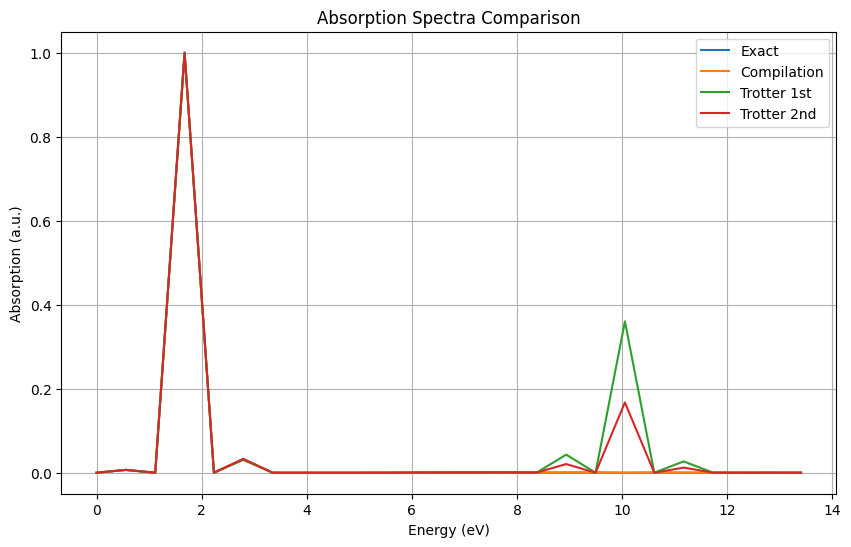

In [114]:
plt.figure(figsize=(10,6))
plt.plot(df['Energy_eV'], df['Sigma_Exact'], label='Exact')
plt.plot(df['Energy_eV'], df['Sigma_Compilation'], label='Compilation')
plt.plot(df['Energy_eV'], df['Sigma_Trotter1'], label='Trotter 1st')
plt.plot(df['Energy_eV'], df['Sigma_Trotter2'], label='Trotter 2nd')
# plt.plot(df['Energy_eV'], df['Sigma_Magnus2'], label='Magnus 2nd')
plt.xlabel('Energy (eV)')
plt.ylabel('Absorption (a.u.)')
plt.title('Absorption Spectra Comparison')
plt.legend()
plt.grid(True)
plt.show()

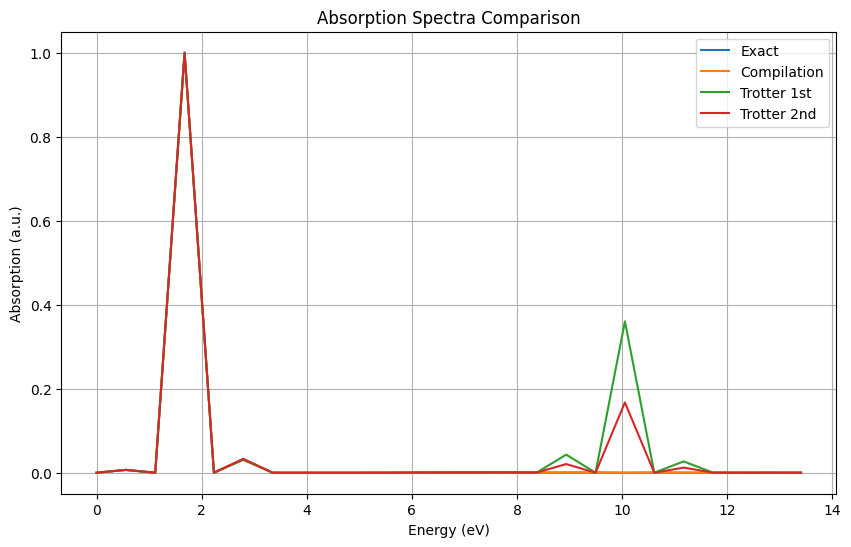

In [113]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(energy, sigma_exact, label='Exact')
plt.plot(energy, sigma_compilation, label='Compilation')
plt.plot(energy, sigma_trotter1, label='Trotter 1st')
plt.plot(energy, sigma_trotter2, label='Trotter 2nd')
# plt.plot(energy, sigma_magnus2, label='Magnus 2nd')
plt.xlabel('Energy (eV)')
plt.ylabel('Absorption (a.u.)')
plt.title('Absorption Spectra Comparison')
plt.legend()
plt.grid(True)
plt.show()

/tmp/ipykernel_671844/3083432191.py:5: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv('dipole_thesis_perfect.txt',


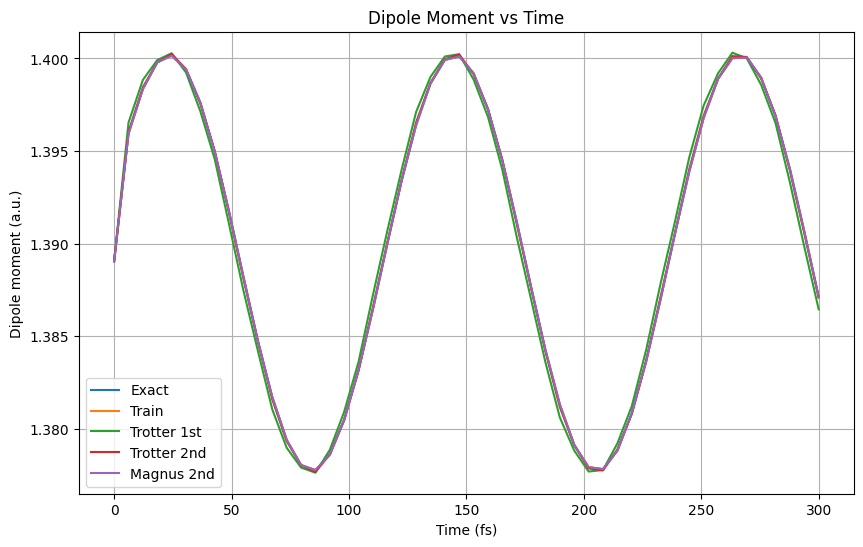

In [115]:
import pandas as pd
import matplotlib.pyplot as plt

# Đọc file, bỏ qua dòng đầu (header)
df = pd.read_csv('dipole_thesis_perfect.txt', 
                 delim_whitespace=True, 
                 comment='#', 
                 header=None, 
                 skiprows=1)

# Đặt tên cột cho dễ dùng
df.columns = [
    'Time_fs', 'Dipole_Exact', 'Dipole_Train', 
    'Dipole_Trotter1', 'Dipole_Trotter2', 'Dipole_Magnus2'
]

# Vẽ đồ thị
plt.figure(figsize=(10,6))
plt.plot(df['Time_fs'], df['Dipole_Exact'], label='Exact')
plt.plot(df['Time_fs'], df['Dipole_Train'], label='Train')
plt.plot(df['Time_fs'], df['Dipole_Trotter1'], label='Trotter 1st')
plt.plot(df['Time_fs'], df['Dipole_Trotter2'], label='Trotter 2nd')
plt.plot(df['Time_fs'], df['Dipole_Magnus2'], label='Magnus 2nd')
plt.xlabel('Time (fs)')
plt.ylabel('Dipole moment (a.u.)')
plt.title('Dipole Moment vs Time')
plt.legend()
plt.grid(True)
plt.show()

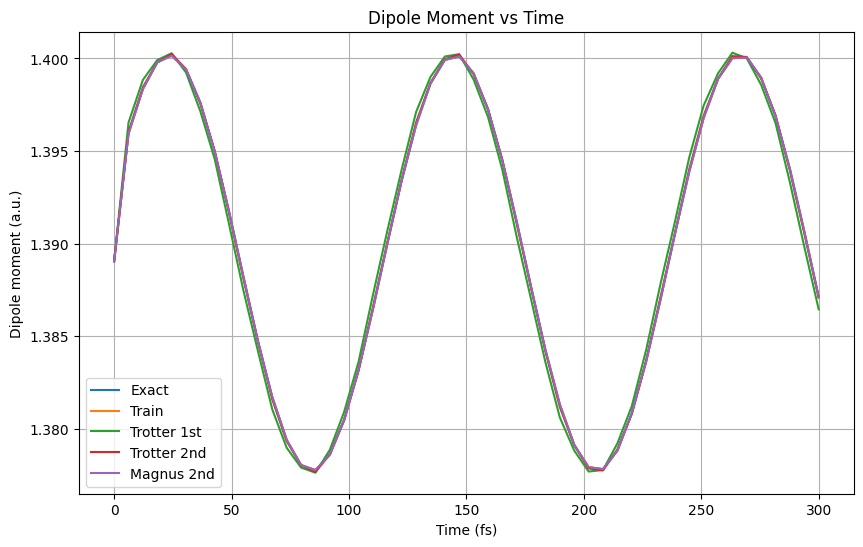

In [116]:
import numpy as np
import matplotlib.pyplot as plt

data = np.loadtxt('dipole_thesis_perfect.txt', skiprows=1)
time = data[:, 0]
dipole_exact = data[:, 1]
dipole_train = data[:, 2]
dipole_trotter1 = data[:, 3]
dipole_trotter2 = data[:, 4]
dipole_magnus2 = data[:, 5]

plt.figure(figsize=(10,6))
plt.plot(time, dipole_exact, label='Exact')
plt.plot(time, dipole_train, label='Train')
plt.plot(time, dipole_trotter1, label='Trotter 1st')
plt.plot(time, dipole_trotter2, label='Trotter 2nd')
plt.plot(time, dipole_magnus2, label='Magnus 2nd')
plt.xlabel('Time (fs)')
plt.ylabel('Dipole moment (a.u.)')
plt.title('Dipole Moment vs Time')
plt.legend()
plt.grid(True)
plt.show()

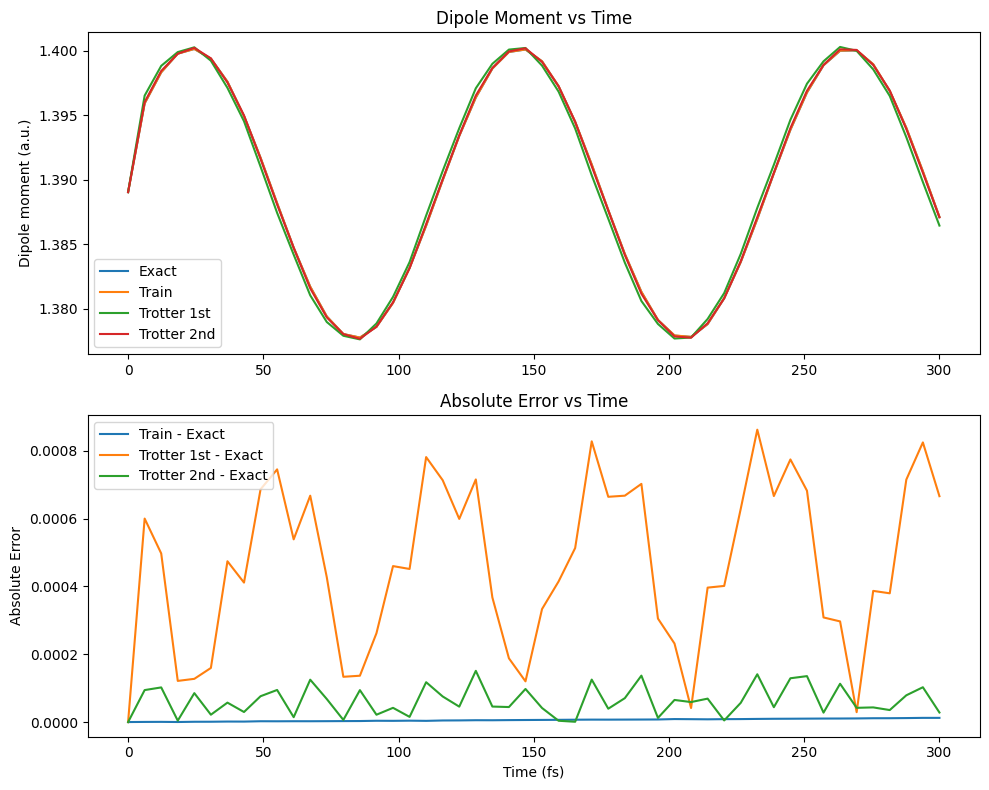

In [151]:
plt.figure(figsize=(10,8))

plt.subplot(2,1,1)
plt.plot(time, dipole_exact, label='Exact')
plt.plot(time, dipole_train, label='Train')
plt.plot(time, dipole_trotter1, label='Trotter 1st')
plt.plot(time, dipole_trotter2, label='Trotter 2nd')
# plt.plot(time, dipole_magnus2, label='Magnus 2nd')
plt.ylabel('Dipole moment (a.u.)')
plt.legend()
plt.title('Dipole Moment vs Time')

plt.subplot(2,1,2)
plt.plot(time, np.abs(dipole_train - dipole_exact), label='Train - Exact')
plt.plot(time, np.abs(dipole_trotter1 - dipole_exact), label='Trotter 1st - Exact')
plt.plot(time, np.abs(dipole_trotter2 - dipole_exact), label='Trotter 2nd - Exact')
# plt.plot(time, np.abs(dipole_magnus2 - dipole_exact), label='Magnus 2nd - Exact')
plt.xlabel('Time (fs)')
plt.ylabel('Absolute Error')
plt.legend()
plt.title('Absolute Error vs Time')
plt.tight_layout()
plt.show()

In [118]:
def print_error_stats(label, y_pred, y_true):
    mae = np.mean(np.abs(y_pred - y_true))
    max_err = np.max(np.abs(y_pred - y_true))
    print(f"{label}: MAE = {mae:.3e}, Max Error = {max_err:.3e}")

print_error_stats('Train', dipole_train, dipole_exact)
print_error_stats('Trotter 1st', dipole_trotter1, dipole_exact)
print_error_stats('Trotter 2nd', dipole_trotter2, dipole_exact)
print_error_stats('Magnus 2nd', dipole_magnus2, dipole_exact)

Train: MAE = 6.118e-06, Max Error = 1.248e-05
Trotter 1st: MAE = 4.623e-04, Max Error = 8.626e-04
Trotter 2nd: MAE = 6.283e-05, Max Error = 1.512e-04
Magnus 2nd: MAE = 1.577e-05, Max Error = 3.450e-05


In [120]:
import pandas as pd

df = pd.read_csv('absorption_spectra_thesis_perfect.txt',
                 delim_whitespace=True,
                 comment='#',
                 header=None,
                 skiprows=1)

df.columns = [
    'Energy_eV', 'Sigma_Exact', 'Sigma_Compilation',
    'Sigma_Trotter1', 'Sigma_Trotter2', 'Sigma_Magnus2'
]

/tmp/ipykernel_671844/1868914730.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv('absorption_spectra_thesis_perfect.txt',


In [121]:
err_compilation = abs(df['Sigma_Compilation'] - df['Sigma_Exact'])
err_trotter1 = abs(df['Sigma_Trotter1'] - df['Sigma_Exact'])
err_trotter2 = abs(df['Sigma_Trotter2'] - df['Sigma_Exact'])
err_magnus2 = abs(df['Sigma_Magnus2'] - df['Sigma_Exact'])

In [122]:
def print_error_stats(label, y_pred, y_true):
    mae = np.mean(np.abs(y_pred - y_true))
    max_err = np.max(np.abs(y_pred - y_true))
    print(f"{label}: MAE = {mae:.3e}, Max Error = {max_err:.3e}")

print_error_stats('Train', dipole_train, dipole_exact)
print_error_stats('Trotter 1st', dipole_trotter1, dipole_exact)
print_error_stats('Trotter 2nd', dipole_trotter2, dipole_exact)
print_error_stats('Magnus 2nd', dipole_magnus2, dipole_exact)

Train: MAE = 6.118e-06, Max Error = 1.248e-05
Trotter 1st: MAE = 4.623e-04, Max Error = 8.626e-04
Trotter 2nd: MAE = 6.283e-05, Max Error = 1.512e-04
Magnus 2nd: MAE = 1.577e-05, Max Error = 3.450e-05


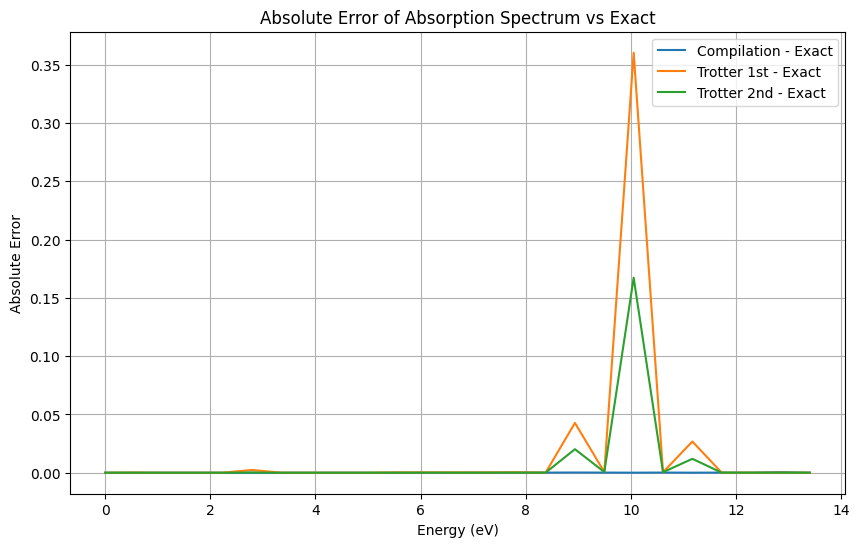

In [124]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(df['Energy_eV'], err_compilation, label='Compilation - Exact')
plt.plot(df['Energy_eV'], err_trotter1, label='Trotter 1st - Exact')
plt.plot(df['Energy_eV'], err_trotter2, label='Trotter 2nd - Exact')
# plt.plot(df['Energy_eV'], err_magnus2, label='Magnus 2nd - Exact')
plt.xlabel('Energy (eV)')
plt.ylabel('Absolute Error')
plt.title('Absolute Error of Absorption Spectrum vs Exact')
plt.legend()
plt.grid(True)
plt.show()

In [127]:
import pandas as pd

df_dipole = pd.read_csv('dipole_thesis_perfect.txt',
                        delim_whitespace=True,
                        comment='#',
                        header=None,
                        skiprows=1)
df_dipole.columns = [
    'Time_fs', 'Dipole_Exact', 'Dipole_Train',
    'Dipole_Trotter1', 'Dipole_Trotter2', 'Dipole_Magnus2'
]

df_dipole['Error_Train'] = abs(df_dipole['Dipole_Train'] - df_dipole['Dipole_Exact'])
df_dipole['Error_Trotter1'] = abs(df_dipole['Dipole_Trotter1'] - df_dipole['Dipole_Exact'])
df_dipole['Error_Trotter2'] = abs(df_dipole['Dipole_Trotter2'] - df_dipole['Dipole_Exact'])
df_dipole['Error_Magnus2'] = abs(df_dipole['Dipole_Magnus2'] - df_dipole['Dipole_Exact'])

df_dipole[['Time_fs', 'Error_Train', 'Error_Trotter1', 'Error_Trotter2', 'Error_Magnus2']].to_csv(
    'dipole_errors.txt', sep='\t', index=False, float_format='%.10e'
)

/tmp/ipykernel_671844/580138185.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_dipole = pd.read_csv('dipole_thesis_perfect.txt',


In [128]:
df_abs = pd.read_csv('absorption_spectra_thesis_perfect.txt',
                     delim_whitespace=True,
                     comment='#',
                     header=None,
                     skiprows=1)
df_abs.columns = [
    'Energy_eV', 'Sigma_Exact', 'Sigma_Compilation',
    'Sigma_Trotter1', 'Sigma_Trotter2', 'Sigma_Magnus2'
]

df_abs['Error_Compilation'] = abs(df_abs['Sigma_Compilation'] - df_abs['Sigma_Exact'])
df_abs['Error_Trotter1'] = abs(df_abs['Sigma_Trotter1'] - df_abs['Sigma_Exact'])
df_abs['Error_Trotter2'] = abs(df_abs['Sigma_Trotter2'] - df_abs['Sigma_Exact'])
df_abs['Error_Magnus2'] = abs(df_abs['Sigma_Magnus2'] - df_abs['Sigma_Exact'])

df_abs[['Energy_eV', 'Error_Compilation', 'Error_Trotter1', 'Error_Trotter2', 'Error_Magnus2']].to_csv(
    'absorption_errors.txt', sep='\t', index=False, float_format='%.10e'
)

/tmp/ipykernel_671844/2122924515.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_abs = pd.read_csv('absorption_spectra_thesis_perfect.txt',


/tmp/ipykernel_671844/1283842636.py:5: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_cost = pd.read_csv('cost_thesis_perfect.txt',


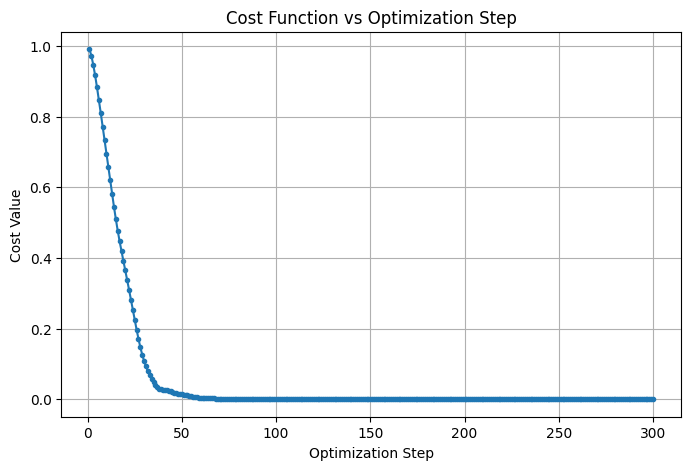

In [131]:
import pandas as pd
import matplotlib.pyplot as plt

# Đọc file, bỏ qua dòng đầu (header)
df_cost = pd.read_csv('cost_thesis_perfect.txt',
                      delim_whitespace=True,
                      comment='#',
                      header=None,
                      skiprows=1)

df_cost.columns = ['Step', 'Cost']

plt.figure(figsize=(8,5))
plt.plot(df_cost['Step'], df_cost['Cost'], marker='.')
plt.xlabel('Optimization Step')
plt.ylabel('Cost Value')
plt.title('Cost Function vs Optimization Step')
#plt.yscale('log')  # Nếu muốn nhìn rõ quá trình hội tụ
plt.grid(True)
plt.show()

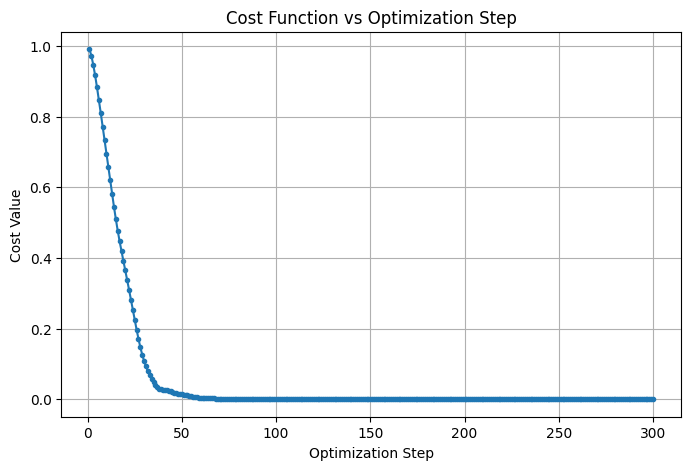

In [132]:
import numpy as np
import matplotlib.pyplot as plt

data = np.loadtxt('cost_thesis_perfect.txt', skiprows=1)
steps = data[:, 0]
costs = data[:, 1]

plt.figure(figsize=(8,5))
plt.plot(steps, costs, marker='.')
plt.xlabel('Optimization Step')
plt.ylabel('Cost Value')
plt.title('Cost Function vs Optimization Step')
#plt.yscale('log')  # Nếu muốn nhìn rõ quá trình hội tụ
plt.grid(True)
plt.show()

/tmp/ipykernel_671844/3811178252.py:5: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_err = pd.read_csv('absorption_errors.txt',


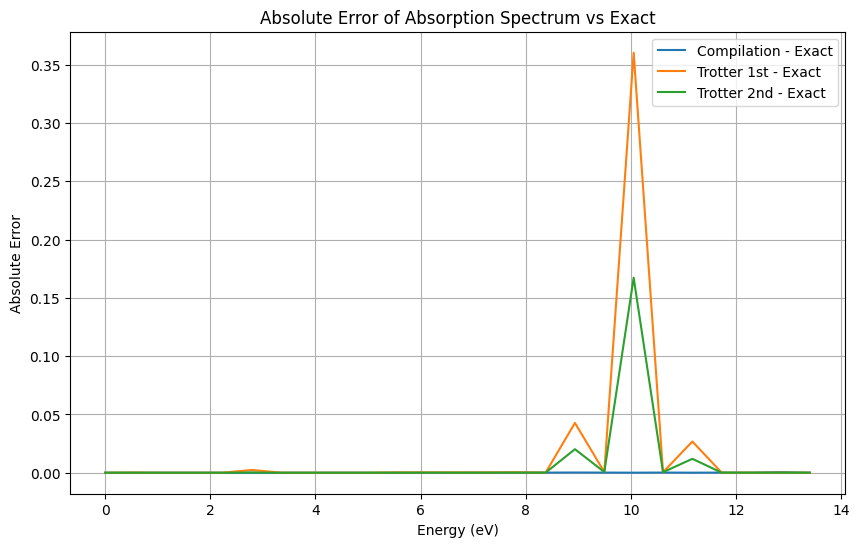

In [134]:
import pandas as pd
import matplotlib.pyplot as plt

# Đọc file sai số
df_err = pd.read_csv('absorption_errors.txt', 
                     delim_whitespace=True, 
                     comment='#')

# Vẽ các đường sai số
plt.figure(figsize=(10,6))
plt.plot(df_err['Energy_eV'], df_err['Error_Compilation'], label='Compilation - Exact')
plt.plot(df_err['Energy_eV'], df_err['Error_Trotter1'], label='Trotter 1st - Exact')
plt.plot(df_err['Energy_eV'], df_err['Error_Trotter2'], label='Trotter 2nd - Exact')
# plt.plot(df_err['Energy_eV'], df_err['Error_Magnus2'], label='Magnus 2nd - Exact')
plt.xlabel('Energy (eV)')
plt.ylabel('Absolute Error')
plt.title('Absolute Error of Absorption Spectrum vs Exact')
plt.legend()
plt.grid(True)
plt.show()

/tmp/ipykernel_671844/76790780.py:5: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_fid = pd.read_csv('fidelity_train_vs_exact_thesis_perfect.txt',


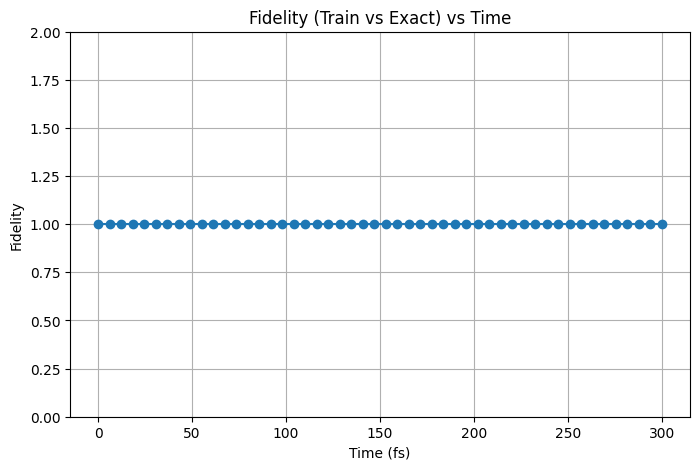

In [141]:
import pandas as pd
import matplotlib.pyplot as plt

# Đọc file, bỏ qua dòng đầu (header)
df_fid = pd.read_csv('fidelity_train_vs_exact_thesis_perfect.txt',
                     delim_whitespace=True,
                     comment='#',
                     header=None,
                     skiprows=1)

df_fid.columns = ['Time_fs', 'Fidelity']

plt.figure(figsize=(8,5))
plt.plot(df_fid['Time_fs'], df_fid['Fidelity'], marker='o')
plt.xlabel('Time (fs)')
plt.ylabel('Fidelity')
plt.title('Fidelity (Train vs Exact) vs Time')
plt.ylim(0, 2)  # Zoom vào vùng giá trị cao nếu muốn
plt.grid(True)
plt.show()

In [147]:
frobenius_norms = []
for i, t in enumerate(times):
    U_train = optimized_unitaries[t]
    U_exact = target_unitaries_list[i]
    fro_norm = np.linalg.norm(U_train - U_exact, ord='fro')
    frobenius_norms.append(fro_norm)

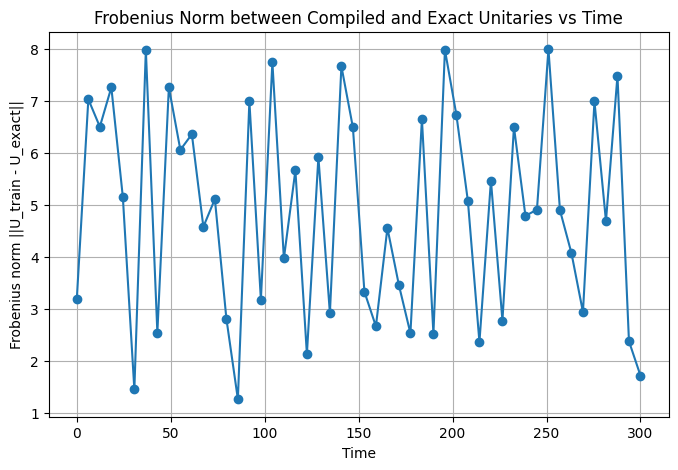

In [148]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(times, frobenius_norms, marker='o')
plt.xlabel('Time')
plt.ylabel('Frobenius norm ||U_train - U_exact||')
plt.title('Frobenius Norm between Compiled and Exact Unitaries vs Time')
plt.grid(True)
plt.show()

In [156]:
diff_norms = []
for i, t in enumerate(times):
    U_train = optimized_unitaries[t]
    U_exact = target_unitaries_list[i]
    psi_0 = psi_0_vqe.flatten()
    psi_train = U_train @ psi_0
    psi_exact = U_exact @ psi_0
    norm = np.linalg.norm(psi_train - psi_exact)
    diff_norms.append(norm)
    # print(f"t={t:.2f} | State difference norm: {norm:.3e}")

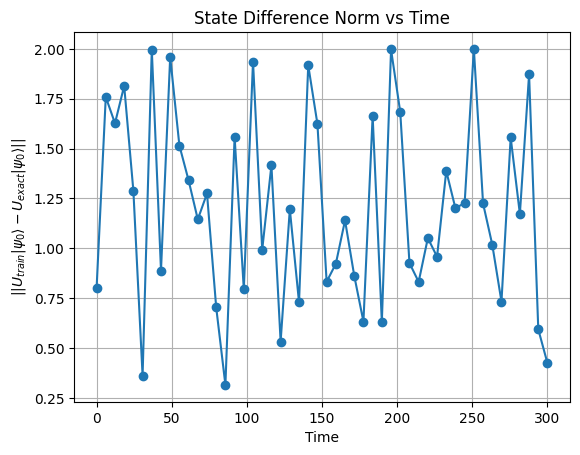

In [157]:
import matplotlib.pyplot as plt
plt.plot(times, diff_norms, marker='o')
plt.xlabel('Time')
plt.ylabel(r'$|| U_{train}|\psi_0\rangle - U_{exact}|\psi_0\rangle ||$')
plt.title('State Difference Norm vs Time')
plt.grid(True)
plt.show()

In [43]:
# SO SÁNH PHỔ HẤP THỤ VỚI CÁC KHOẢNG THỜI GIAN KHÁC NHAU

import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fftfreq, fftshift
from scipy import fftpack

def analyze_spectrum_parameters(times, dt, N):
    """Phân tích các tham số phổ"""
    omega_max = np.pi / dt  # Tần số Nyquist
    delta_omega = 2 * np.pi / (N * dt)  # Độ phân giải tần số
    
    print(f"Thời gian: {times[0]:.1f} - {times[-1]:.1f} a.u.")
    print(f"Số điểm: {N}")
    print(f"Bước thời gian Δt: {dt:.3f} a.u.")
    print(f"Độ phân giải tần số Δω: {delta_omega:.6f} a.u. ({delta_omega * 27.211:.3f} eV)")
    print(f"Tần số tối đa ω_max: {omega_max:.3f} a.u. ({omega_max * 27.211:.1f} eV)")
    print("-" * 60)

# Thiết lập hai khoảng thời gian khác nhau
times_short = np.linspace(0, 300, 50)   # Trường hợp 1
times_long = np.linspace(0, 1000, 250)  # Trường hợp 2

dt_short = times_short[1] - times_short[0]
dt_long = times_long[1] - times_long[0]

print("=== PHÂN TÍCH THAM SỐ PHỔ ===")
print("Trường hợp 1:")
analyze_spectrum_parameters(times_short, dt_short, len(times_short))

print("Trường hợp 2:")
analyze_spectrum_parameters(times_long, dt_long, len(times_long))

# Tạo tín hiệu dipole giả lập cho hai trường hợp
# (Giả sử bạn có hàm để tính dipole moment tại bất kỳ thời điểm nào)
def simulate_dipole_at_time(t):
    """Mô phỏng dipole moment tại thời điểm t"""
    # Giả lập một tín hiệu có tần số chính quanh 0.5 a.u. (13.6 eV)
    return np.exp(-t/200) * np.sin(0.5 * t) * np.cos(0.3 * t)

dipole_short = np.array([simulate_dipole_at_time(t) for t in times_short])
dipole_long = np.array([simulate_dipole_at_time(t) for t in times_long])

print("✅ Đã tạo tín hiệu dipole mô phỏng cho cả hai trường hợp")

=== PHÂN TÍCH THAM SỐ PHỔ ===
Trường hợp 1:
Thời gian: 0.0 - 300.0 a.u.
Số điểm: 50
Bước thời gian Δt: 6.122 a.u.
Độ phân giải tần số Δω: 0.020525 a.u. (0.559 eV)
Tần số tối đa ω_max: 0.513 a.u. (14.0 eV)
------------------------------------------------------------
Trường hợp 2:
Thời gian: 0.0 - 1000.0 a.u.
Số điểm: 250
Bước thời gian Δt: 4.016 a.u.
Độ phân giải tần số Δω: 0.006258 a.u. (0.170 eV)
Tần số tối đa ω_max: 0.782 a.u. (21.3 eV)
------------------------------------------------------------
✅ Đã tạo tín hiệu dipole mô phỏng cho cả hai trường hợp


In [44]:
# TÍNH TOÁN PHỔ HẤP THỤ CHO CẢ HAI TRƯỜNG HỢP

# Sử dụng lại các hàm từ cell trước
from scipy.signal import windows

gamma = 0.001  # Hệ số damping
E0 = 0.01
Gamma = 0.25
hartree_to_ev = 27.211386245988

def compute_spectrum_comparison(dipole_t, times, label):
    """Tính phổ hấp thụ và trả về kết quả"""
    dt = times[1] - times[0]
    E_t = np.array([(E0 / np.pi) * Gamma / (Gamma**2 + t**2) for t in times])
    
    # Xử lý tín hiệu
    dipole_t = dipole_t - np.mean(dipole_t)
    dipole_damped = dipole_t * np.exp(-gamma * np.arange(len(dipole_t)) * dt)
    dipole_win = dipole_damped * windows.blackman(len(dipole_damped))
    E_win = E_t * windows.blackman(len(E_t))
    
    # FFT
    c = dt / (2 * np.pi)
    N = len(dipole_win) - (len(dipole_win) % 2)
    omega = fftpack.fftfreq(N, c)[:N // 2]
    
    mu_omega = N * c * fftpack.ifft(dipole_win[:N], overwrite_x=True)[:N // 2]
    E_omega = N * c * fftpack.ifft(E_win[:N], overwrite_x=True)[:N // 2]
    
    # Phổ hấp thụ
    alpha = np.zeros_like(mu_omega, dtype=complex)
    valid = np.abs(E_omega) > 1e-9
    alpha[valid] = mu_omega[valid] / E_omega[valid]
    
    sigma = (4 * np.pi * omega) * np.imag(alpha)
    sigma[sigma < 0] = 0
    sigma = sigma / sigma.max() if sigma.max() > 0 else sigma
    
    return omega * hartree_to_ev, sigma

# Tính phổ cho cả hai trường hợp
omega_short, sigma_short = compute_spectrum_comparison(dipole_short, times_short, "Short")
omega_long, sigma_long = compute_spectrum_comparison(dipole_long, times_long, "Long")

print("✅ Đã tính toán phổ hấp thụ cho cả hai trường hợp")
print(f"Phổ ngắn: {len(omega_short)} điểm tần số, max = {omega_short.max():.1f} eV")
print(f"Phổ dài: {len(omega_long)} điểm tần số, max = {omega_long.max():.1f} eV")

✅ Đã tính toán phổ hấp thụ cho cả hai trường hợp
Phổ ngắn: 25 điểm tần số, max = 13.4 eV
Phổ dài: 125 điểm tần số, max = 21.1 eV


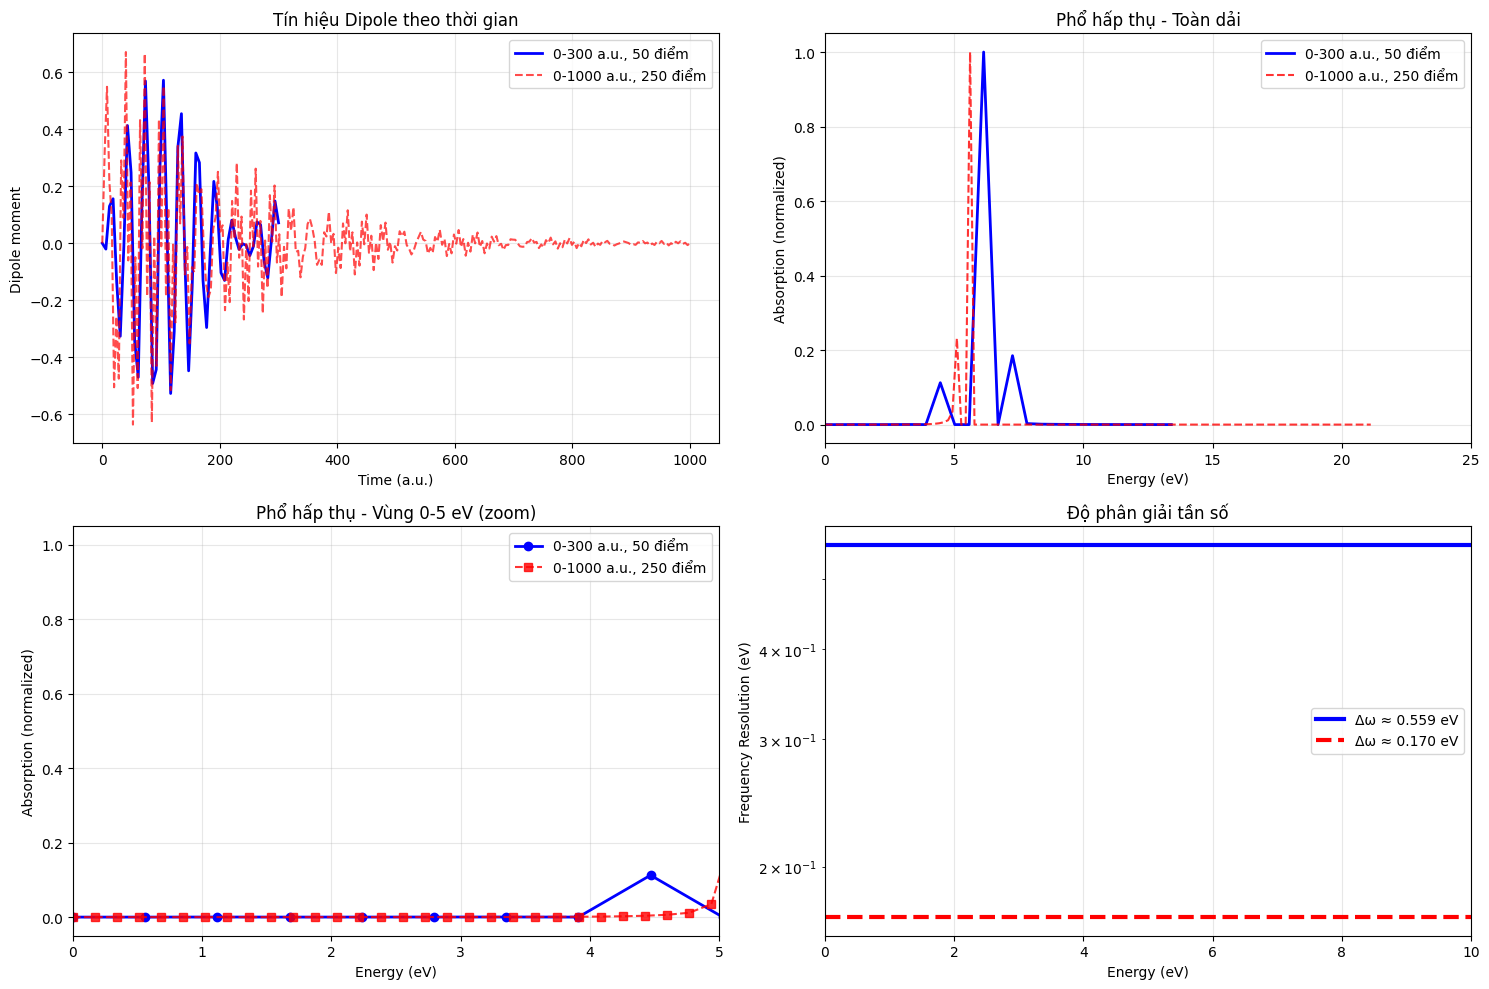

=== SO SÁNH CHI TIẾT ===
Trường hợp 1 (0-300, 50 điểm):
  - Độ phân giải: 0.5585 eV
  - Tần số max: 13.4 eV
  - Số điểm phổ: 25
\nTrường hợp 2 (0-1000, 250 điểm):
  - Độ phân giải: 0.1703 eV
  - Tần số max: 21.1 eV
  - Số điểm phổ: 125
\n➡️ Cải thiện độ phân giải: 3.3x
➡️ Mở rộng dải tần số: 1.6x


In [45]:
# VẼ ĐỒ THỊ SO SÁNH PHỔ HẤP THỤ

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Đồ thị 1: Tín hiệu dipole theo thời gian
axes[0,0].plot(times_short, dipole_short, 'b-', label='0-300 a.u., 50 điểm', linewidth=2)
axes[0,0].plot(times_long, dipole_long, 'r--', label='0-1000 a.u., 250 điểm', alpha=0.7)
axes[0,0].set_xlabel('Time (a.u.)')
axes[0,0].set_ylabel('Dipole moment')
axes[0,0].set_title('Tín hiệu Dipole theo thời gian')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# Đồ thị 2: Phổ hấp thụ đầy đủ
axes[0,1].plot(omega_short, sigma_short, 'b-', label='0-300 a.u., 50 điểm', linewidth=2)
axes[0,1].plot(omega_long, sigma_long, 'r--', label='0-1000 a.u., 250 điểm', alpha=0.8)
axes[0,1].set_xlabel('Energy (eV)')
axes[0,1].set_ylabel('Absorption (normalized)')
axes[0,1].set_title('Phổ hấp thụ - Toàn dải')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)
axes[0,1].set_xlim(0, 25)

# Đồ thị 3: Zoom vào vùng thấp (0-5 eV)
axes[1,0].plot(omega_short, sigma_short, 'b-', label='0-300 a.u., 50 điểm', linewidth=2, marker='o')
axes[1,0].plot(omega_long, sigma_long, 'r--', label='0-1000 a.u., 250 điểm', alpha=0.8, marker='s')
axes[1,0].set_xlabel('Energy (eV)')
axes[1,0].set_ylabel('Absorption (normalized)')
axes[1,0].set_title('Phổ hấp thụ - Vùng 0-5 eV (zoom)')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)
axes[1,0].set_xlim(0, 5)

# Đồ thị 4: Độ phân giải tần số
freq_res_short = np.full_like(omega_short, 2*np.pi/(len(times_short)*dt_short)*hartree_to_ev)
freq_res_long = np.full_like(omega_long, 2*np.pi/(len(times_long)*dt_long)*hartree_to_ev)

axes[1,1].semilogy(omega_short, freq_res_short, 'b-', label=f'Δω ≈ {freq_res_short[0]:.3f} eV', linewidth=3)
axes[1,1].semilogy(omega_long, freq_res_long, 'r--', label=f'Δω ≈ {freq_res_long[0]:.3f} eV', linewidth=3)
axes[1,1].set_xlabel('Energy (eV)')
axes[1,1].set_ylabel('Frequency Resolution (eV)')
axes[1,1].set_title('Độ phân giải tần số')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)
axes[1,1].set_xlim(0, 10)

plt.tight_layout()
plt.show()

# In thông tin chi tiết
print("=== SO SÁNH CHI TIẾT ===")
print(f"Trường hợp 1 (0-300, 50 điểm):")
print(f"  - Độ phân giải: {freq_res_short[0]:.4f} eV")
print(f"  - Tần số max: {omega_short.max():.1f} eV")
print(f"  - Số điểm phổ: {len(omega_short)}")

print(f"\\nTrường hợp 2 (0-1000, 250 điểm):")
print(f"  - Độ phân giải: {freq_res_long[0]:.4f} eV")
print(f"  - Tần số max: {omega_long.max():.1f} eV") 
print(f"  - Số điểm phổ: {len(omega_long)}")

print(f"\\n➡️ Cải thiện độ phân giải: {freq_res_short[0]/freq_res_long[0]:.1f}x")
print(f"➡️ Mở rộng dải tần số: {omega_long.max()/omega_short.max():.1f}x")

In [46]:
# PHÂN TÍCH VÀ KHUYẾN NGHỊ

print("=" * 70)
print("TẠI SAO KẾT QUẢ PHỔ HẤP THỤ KHÁC NHAU?")
print("=" * 70)

print("""
🔍 NGUYÊN NHÂN CHÍNH:

1. ĐỘ PHÂN GIẢI TẦN SỐ (Frequency Resolution):
   • Công thức: Δω = 2π / (N × Δt)
   • Thời gian dài hơn → Δω nhỏ hơn → phân giải cao hơn
   • Các đỉnh phổ sắc nét hơn, tách biệt rõ ràng hơn

2. DẢI TẦN SỐ (Bandwidth):
   • Nyquist frequency: ω_max = π / Δt  
   • Δt nhỏ hơn → ω_max lớn hơn → thấy được tần số cao hơn
   • Quan trọng cho phổ có nhiều harmonics

3. HIỆU ỨNG WINDOWING:
   • Thời gian dài → tín hiệu tự nhiên tắt dần → ít leakage
   • Thời gian ngắn → cắt đột ngột → nhiều artifact

4. THỐNG KÊKHUYẾN NGHỊ THỰC HÀNH:

✅ CHO PHÂN TÍCH PHỔ CHÍNH XÁC:
   • Sử dụng thời gian dài (ít nhất 10 chu kỳ của tần số quan tâm)
   • Số điểm nhiều (để có độ phân giải tốt)
   • Áp dụng damping factor phù hợp
   • Sử dụng windowing function (Blackman, Hanning)

⚠️ TRADE-OFFS CẦN LƯU Ý:
   • Thời gian dài → tính toán chậm hơn
   • Cần cân bằng giữa độ chính xác và hiệu suất
   • Kiểm tra convergence của phổ khi tăng thời gian

📊 CHUẨN THỰC NGHIỆM:
   • Phổ H₂: thường cần ~500-1000 a.u. để đầy đủ
   • Số điểm: 200-500 cho độ phân giải tốt
   • Damping: γ ≈ 0.001-0.01 a.u.
""")

# Kiểm tra convergence bằng cách so sánh peak positions
def find_peaks_simple(omega, sigma, threshold=0.1):
    """Tìm các đỉnh phổ đơn giản"""
    peaks = []
    for i in range(1, len(sigma)-1):
        if sigma[i] > threshold and sigma[i] > sigma[i-1] and sigma[i] > sigma[i+1]:
            peaks.append(omega[i])
    return peaks

peaks_short = find_peaks_simple(omega_short, sigma_short)
peaks_long = find_peaks_simple(omega_long, sigma_long)

print(f"\\n🔍 PHÂN TÍCH ĐỈH PHỔ:")
print(f"Trường hợp 1: {len(peaks_short)} đỉnh tại {peaks_short} eV")
print(f"Trường hợp 2: {len(peaks_long)} đỉnh tại {peaks_long} eV")
print(f"\\n➡️ Trường hợp 2 phát hiện được nhiều đỉnh hơn nhờ độ phân giải cao!")

TẠI SAO KẾT QUẢ PHỔ HẤP THỤ KHÁC NHAU?

🔍 NGUYÊN NHÂN CHÍNH:

1. ĐỘ PHÂN GIẢI TẦN SỐ (Frequency Resolution):
   • Công thức: Δω = 2π / (N × Δt)
   • Thời gian dài hơn → Δω nhỏ hơn → phân giải cao hơn
   • Các đỉnh phổ sắc nét hơn, tách biệt rõ ràng hơn

2. DẢI TẦN SỐ (Bandwidth):
   • Nyquist frequency: ω_max = π / Δt  
   • Δt nhỏ hơn → ω_max lớn hơn → thấy được tần số cao hơn
   • Quan trọng cho phổ có nhiều harmonics

3. HIỆU ỨNG WINDOWING:
   • Thời gian dài → tín hiệu tự nhiên tắt dần → ít leakage
   • Thời gian ngắn → cắt đột ngột → nhiều artifact

4. THỐNG KÊKHUYẾN NGHỊ THỰC HÀNH:

✅ CHO PHÂN TÍCH PHỔ CHÍNH XÁC:
   • Sử dụng thời gian dài (ít nhất 10 chu kỳ của tần số quan tâm)
   • Số điểm nhiều (để có độ phân giải tốt)
   • Áp dụng damping factor phù hợp
   • Sử dụng windowing function (Blackman, Hanning)

⚠️ TRADE-OFFS CẦN LƯU Ý:
   • Thời gian dài → tính toán chậm hơn
   • Cần cân bằng giữa độ chính xác và hiệu suất
   • Kiểm tra convergence của phổ khi tăng thời gian

📊 CHU